In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import cv2 
from PIL import Image
from glob import glob
import os 
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

print('libs have imported')

libs have imported


In [3]:
os.getcwd()

'd:\\Data\\Machine\\Project'

In [4]:
%ls

 Volume in drive D has no label.
 Volume Serial Number is 4C4E-D993

 Directory of d:\Data\Machine\Project

05/31/2021  06:19 AM    <DIR>          .
05/31/2021  06:19 AM    <DIR>          ..
05/31/2021  06:19 AM    <DIR>          .ipynb_checkpoints
05/11/2021  07:10 AM    <DIR>          __pycache__
04/24/2021  04:51 AM         1,838,703 1-Understanding Images.ipynb
05/31/2021  07:33 AM           534,975 2-Object  Detection.ipynb
04/24/2021  11:13 PM           484,452 3-Image Croping.ipynb
05/31/2021  07:30 AM    <DIR>          Data
05/07/2021  10:00 AM    <DIR>          faceoff
05/11/2021  10:06 AM    <DIR>          flask
05/31/2021  06:19 AM    <DIR>          images
05/07/2021  11:47 AM           726,223 main.ipynb
05/31/2021  04:52 AM    <DIR>          models
05/31/2021  05:53 AM            84,798 Pipeline.ipynb
05/07/2021  10:00 AM               213 README.md
05/07/2021  11:34 AM                80 requirements.txt
05/31/2021  06:19 AM             2,942 scraper.ipynb
04/24/2021  07:2

In [5]:
# male croped images 
male = glob('./Data/data/male_crop/*.jpg')
# female croped images 
female = glob('./Data/data/female_crop/*.jpg')
# collect all images paths 
path = male + female 

In [6]:
male[:20]

['./Data/data/male_crop\\male_0.jpg',
 './Data/data/male_crop\\male_1.jpg',
 './Data/data/male_crop\\male_10.jpg',
 './Data/data/male_crop\\male_1003.jpg',
 './Data/data/male_crop\\male_1004.jpg',
 './Data/data/male_crop\\male_1008.jpg',
 './Data/data/male_crop\\male_1009.jpg',
 './Data/data/male_crop\\male_101.jpg',
 './Data/data/male_crop\\male_1011.jpg',
 './Data/data/male_crop\\male_1012.jpg',
 './Data/data/male_crop\\male_1014.jpg',
 './Data/data/male_crop\\male_1015.jpg',
 './Data/data/male_crop\\male_1017.jpg',
 './Data/data/male_crop\\male_1018.jpg',
 './Data/data/male_crop\\male_1020.jpg',
 './Data/data/male_crop\\male_1027.jpg',
 './Data/data/male_crop\\male_1029.jpg',
 './Data/data/male_crop\\male_1032.jpg',
 './Data/data/male_crop\\male_1034.jpg',
 './Data/data/male_crop\\male_1035.jpg']

In [7]:
len(male) , len(female) , len(path)

(717, 1109, 1826)

In [8]:
# get the size of the image 
def getSize(path):
    img = Image.open(path)
    return img.size[0]   # get height or width only

In [9]:
getSize(path[0])

273

In [10]:
# create DF 
df = pd.DataFrame(data=path, columns=['path'])
df.head()

,path
0,./Data/data/male_crop\male_0.jpg
1,./Data/data/male_crop\male_1.jpg
2,./Data/data/male_crop\male_10.jpg
3,./Data/data/male_crop\male_1003.jpg
4,./Data/data/male_crop\male_1004.jpg


In [11]:
df.shape

(1826, 1)

In [12]:
# lets apply getSize funtion for each path 
df['size'] = df['path'].apply(getSize)

In [13]:
df.head()

,path,size
0,./Data/data/male_crop\male_0.jpg,273
1,./Data/data/male_crop\male_1.jpg,273
2,./Data/data/male_crop\male_10.jpg,273
3,./Data/data/male_crop\male_1003.jpg,182
4,./Data/data/male_crop\male_1004.jpg,81


## EDA 

In [14]:
# we read the data lets analyze what is the proper size we need to be considered 

df.describe()

,size
count,1826.000000
mean,219.941950
std,187.852568
min,24.000000
25%,122.000000
50%,182.000000
75%,273.000000
max,2076.000000


<function matplotlib.pyplot.show(close=None, block=None)>

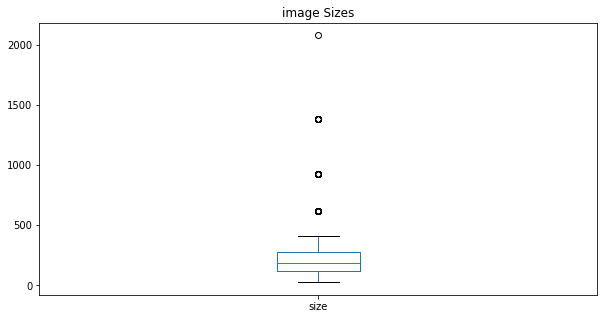

In [15]:
plt.figure(figsize=(10,5))
df['size'].plot(kind='box')
plt.title('image Sizes')
plt.show

In [16]:
# we have outliers 

<function matplotlib.pyplot.show(close=None, block=None)>

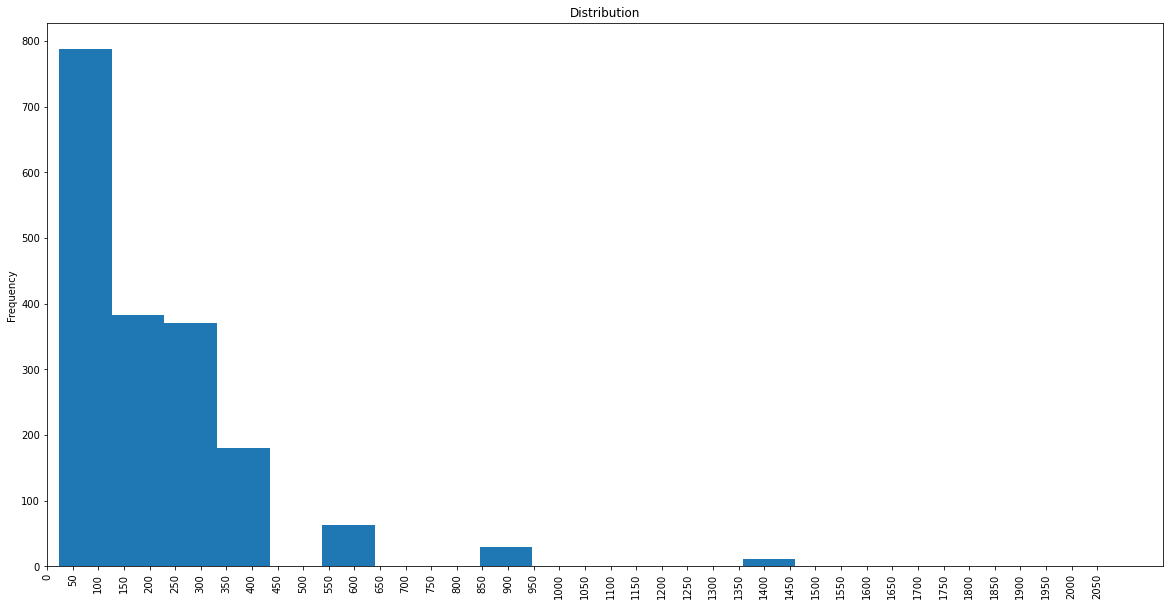

In [17]:
plt.figure(figsize=(20,10))
df['size'].plot(kind='hist', bins=20)
plt.xticks(np.arange(0,2100,step=50))
plt.xticks(rotation=90)
plt.xlim(0)
plt.title('Distribution')
plt.show

In [18]:
# i will resize my images 200*200 as most of the images are falling in that portion of the dist. 
# will remove the imageS of size less than 70 and images more than 650

condition = df[(df['size'] > 70) & (df['size'] < 650)]
len(condition)

1620

In [19]:
# after filtering lets create new dataframe 
data = condition
data.head()

,path,size
0,./Data/data/male_crop\male_0.jpg,273
1,./Data/data/male_crop\male_1.jpg,273
2,./Data/data/male_crop\male_10.jpg,273
3,./Data/data/male_crop\male_1003.jpg,182
4,./Data/data/male_crop\male_1004.jpg,81


In [20]:
data.shape , df.shape

((1620, 2), (1826, 2))

In [21]:
# create label for each image 
def get_label(path):
    
    try : 
    
        #path = data['path'][path]
        first_split = path.split('_')[0]
        second_split = first_split.split('/')[-1]
        
        return second_split

    except: 
        
        return None 
    
data['gender'] = data['path'].apply(get_label)

In [22]:
data.head()

,path,size,gender
0,./Data/data/male_crop\male_0.jpg,273,male
1,./Data/data/male_crop\male_1.jpg,273,male
2,./Data/data/male_crop\male_10.jpg,273,male
3,./Data/data/male_crop\male_1003.jpg,182,male
4,./Data/data/male_crop\male_1004.jpg,81,male


In [23]:
data.tail()

,path,size,gender
1821,./Data/data/female_crop\female_994.jpg,182,female
1822,./Data/data/female_crop\female_995.jpg,273,female
1823,./Data/data/female_crop\female_996.jpg,273,female
1824,./Data/data/female_crop\female_998.jpg,273,female
1825,./Data/data/female_crop\female_999.jpg,122,female


In [24]:
data.gender.value_counts()

female    980
male      640
Name: gender, dtype: int64

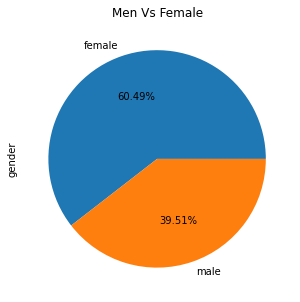

In [25]:
plt.figure(figsize=(10,5))
data.gender.value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.title('Men Vs Female')
plt.show()

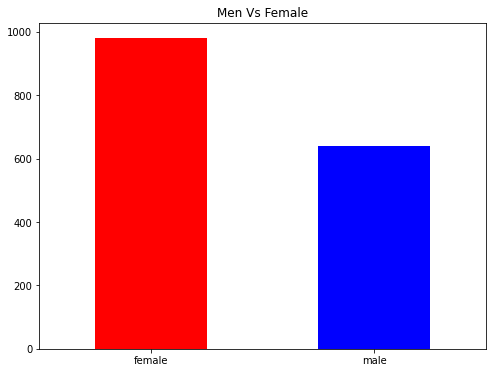

In [26]:
plt.figure(figsize=(8,6))
data.gender.value_counts().plot(kind='bar' , color=['red','blue'])
plt.title('Men Vs Female')
plt.xticks(rotation=0)
plt.show()

In [27]:
# its quite balanced  60% to 40%  
#the minimum image size is 81 
# resizing all the images by 200*200 
data['size'].min()

81

## Resizing images 

In [28]:
data.head()

,path,size,gender
0,./Data/data/male_crop\male_0.jpg,273,male
1,./Data/data/male_crop\male_1.jpg,273,male
2,./Data/data/male_crop\male_10.jpg,273,male
3,./Data/data/male_crop\male_1003.jpg,182,male
4,./Data/data/male_crop\male_1004.jpg,81,male


In [29]:
# considering one image 
path = data['path'][0]
# read the image 
img = cv2.imread(path)
# convert it to grayscale 
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# resize the image by 200* 200
size = gray.shape[0]
if size >= 200 :
    # shrink the image 
    gray_resize = cv2.resize(gray, (200,200),cv2.INTER_AREA)  
else :
    # enlarge the image
    gray_resize = cv2.resize(gray, (200,200),cv2.INTER_CUBIC)

# flatten the image after resizing (1x40000)
flat_img = gray_resize.flatten()

before : 273
after : (200, 200)


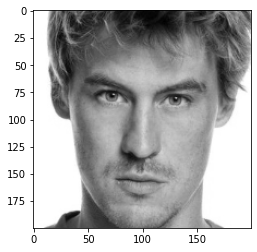

In [30]:
plt.imshow(gray_resize,cmap='gray')
print(f"before : {data['size'][0]}")
print(f'after : {gray_resize.shape}')

# shrinked 

In [31]:
def resizing(path):
    try : 
        # read the image 
        img = cv2.imread(path)
        # convert it to grayscale 
        gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # resize the image by 200* 200
        size = gray.shape[0]
        if size >= 200 :
            # shrink the image 
            gray_resize = cv2.resize(gray, (200,200),cv2.INTER_AREA)  
        else :
            # enlarge the image
            gray_resize = cv2.resize(gray, (200,200),cv2.INTER_CUBIC)

        # flatten the image after resizing (1x40000)
        flat_img = gray_resize.flatten()

        return flat_img
    except:
        None

In [32]:
# applying our func to all paths 
data['opt_size'] = data['path'].apply(resizing)

In [33]:
data.head()

,path,size,gender,opt_size
0,./Data/data/male_crop\male_0.jpg,273,male,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1,./Data/data/male_crop\male_1.jpg,273,male,"[82, 84, 90, 89, 89, 89, 88, 83, 74, 66, 76, 7..."
2,./Data/data/male_crop\male_10.jpg,273,male,"[246, 246, 247, 247, 247, 247, 248, 247, 242, ..."
3,./Data/data/male_crop\male_1003.jpg,182,male,"[190, 187, 189, 190, 190, 180, 153, 111, 64, 2..."
4,./Data/data/male_crop\male_1004.jpg,81,male,"[168, 168, 167, 166, 166, 167, 167, 167, 167, ..."


In [34]:
len(data['opt_size'])

1620

In [35]:
df = data['opt_size']
pd.Series(df[0])

0        255
1        255
2        255
3        255
4        255
        ... 
39995    255
39996    255
39997    255
39998    255
39999    255
Length: 40000, dtype: uint8

In [36]:
# expand flatten images into df 
df = data['opt_size'].apply(pd.Series)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,82,84,90,89,89,89,88,83,74,66,...,18,18,18,18,17,17,17,16,15,15
2,246,246,247,247,247,247,248,247,242,245,...,247,246,246,245,245,245,246,246,246,246
3,190,187,189,190,190,180,153,111,64,22,...,2,2,2,2,2,2,2,2,2,2
4,168,168,167,166,166,167,167,167,167,168,...,159,155,164,173,179,183,187,185,183,183


In [37]:
# rows are the no. of images and the cols are the no. of features
df.shape

(1620, 40000)

In [38]:
# lets concat our gender col to our flatten dataframe 
final = pd.concat([data['gender'],df], axis=1)
final.head()

,gender,0,1,2,3,4,5,6,7,8,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,male,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,male,82,84,90,89,89,89,88,83,74,...,18,18,18,18,17,17,17,16,15,15
2,male,246,246,247,247,247,247,248,247,242,...,247,246,246,245,245,245,246,246,246,246
3,male,190,187,189,190,190,180,153,111,64,...,2,2,2,2,2,2,2,2,2,2
4,male,168,168,167,166,166,167,167,167,167,...,159,155,164,173,179,183,187,185,183,183


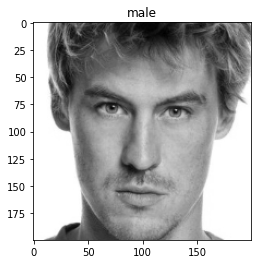

In [39]:
plt.imshow(final.loc[0][1:].values.
           reshape(200,200).astype('int'),
          cmap='gray')
plt.title(final.loc[0]['gender'])
plt.show()

In [40]:
final.loc[0]['gender']

'male'

In [41]:
# save dataframe for later use
os.getcwd()
pickle.dump(final, open('./Data/data/flatten_images.pickle','wb'))

## Data Preprocessing 

In [42]:
#lets load our data from the pickled file 
df = pickle.load(open('./Data/data/flatten_images.pickle','rb'))
df.head()

,gender,0,1,2,3,4,5,6,7,8,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,male,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,male,82,84,90,89,89,89,88,83,74,...,18,18,18,18,17,17,17,16,15,15
2,male,246,246,247,247,247,247,248,247,242,...,247,246,246,245,245,245,246,246,246,246
3,male,190,187,189,190,190,180,153,111,64,...,2,2,2,2,2,2,2,2,2,2
4,male,168,168,167,166,166,167,167,167,167,...,159,155,164,173,179,183,187,185,183,183


In [43]:
# check the df cols datatypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1620 entries, 0 to 1825
Columns: 40001 entries, gender to 39999
dtypes: object(1), uint8(40000)
memory usage: 61.8+ MB


In [44]:
# check for null values 
df.isnull().sum().sum()

0

In [45]:
# show some statistics about the data 
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,...,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,114.906173,113.908642,113.093827,111.808642,111.046914,109.879630,109.075926,108.527778,107.398765,106.414815,...,96.550617,97.233333,97.875309,97.882716,98.316049,98.617901,98.967284,98.996296,99.456173,99.606790
std,79.430041,79.002672,78.542419,78.451776,78.242107,77.923322,77.543451,77.192386,76.895782,76.341174,...,73.735328,73.813480,74.100764,74.478370,74.572200,74.461246,74.746908,74.836094,74.492178,74.669122
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,42.000000,42.000000,42.000000,41.750000,41.000000,41.000000,41.000000,40.750000,39.000000,...,33.000000,33.750000,34.000000,33.750000,35.000000,36.000000,35.000000,35.000000,36.000000,36.000000
50%,100.000000,99.500000,96.000000,95.000000,93.000000,92.000000,91.000000,90.000000,89.000000,88.000000,...,78.000000,79.500000,79.000000,79.000000,79.000000,79.000000,81.000000,80.000000,81.000000,81.000000
75%,185.000000,182.250000,178.250000,178.000000,175.000000,175.000000,174.000000,173.000000,172.000000,169.000000,...,151.000000,152.000000,153.000000,154.000000,156.000000,154.000000,155.500000,157.000000,155.000000,156.250000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [46]:
# df.dropna(axis=0, inplace=True)
# check

In [47]:
# data normalization 
# since the normalizatio only applied input values 
# split the data into x,y 

# independent variables 
X = df.iloc[:,1:].values   # values convert it to array 
# dependent variable 
y = df.iloc[:,0].values

In [48]:
X.shape , y.shape

((1620, 40000), (1620,))

In [49]:
# using min max scaler 
# x - min_value / max_value - min_value

# since its image im expecting that its range values from 0 - 255
min_value = X.min()
max_value = X.max()
print(f' min_value = {min_value} \n max_value = {max_value}')

 min_value = 0 
 max_value = 255


In [50]:
X_norm = (X - min_value) / (max_value - min_value)
X_norm

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.32156863, 0.32941176, 0.35294118, ..., 0.0627451 , 0.05882353,
        0.05882353],
       [0.96470588, 0.96470588, 0.96862745, ..., 0.96470588, 0.96470588,
        0.96470588],
       ...,
       [0.24705882, 0.25882353, 0.26666667, ..., 0.13333333, 0.12156863,
        0.11372549],
       [0.29019608, 0.28627451, 0.15294118, ..., 0.45098039, 0.4745098 ,
        0.53333333],
       [0.11764706, 0.12156863, 0.13333333, ..., 0.03529412, 0.03529412,
        0.03529412]])

In [51]:
X_norm.shape

(1620, 40000)

In [52]:
# convert male to 0 and female to 1
y = np.where(y=='female',1,0)   # else = 0 => man

In [53]:
y.shape

(1620,)

In [54]:
# saving into zip format 
np.savez('./Data/data/normalized_data',X_norm,y)

## EigenFaces (PCA)

# extracting features from the images using PCA (principal component analysis)

faces can be constructed. They are blurry depictions of faces that each highlight a certain type of feature. They are used in facial characterization and recognition applications.

The idea is that anyone’s face can be reconstructed from a suitable linear combination of eigenfaces. Your face would be 7% Face A, 3.4 % Face B, and so on, while someone else’s face would have a different combination of those same eigenfaces.

Eigenfaces are constructed by training on a set of real faces. By matrix manipulation, it is possible to mathematically identify “features”, and assign a strength level to each feature for a given face. The goal is to create the minimum number of eigenfaces that can adequately represent the entire training set (hence it is a type of Principal Component Analysis). If the training set is sufficiently diverse, the resulting set of eigenfaces should be able to represent all faces.

The word eigenfaces is in analogy with eigenvalues and eigenvectors

Anyway, eigenfaces are basically the same. They are “vectors” extracted from data sets of images of human faces. Just like the example above, it is transforming a bunch of images of faces from “a bit of this pixel plus a bit of this pixel plus a bit of this pixel plus…” into “a bit of this eigenface plus a bit of this eigenface plus a bit of this eigenface plus…”

Storing information this way has important uses in image processing, such as face detection and face recognition systems.

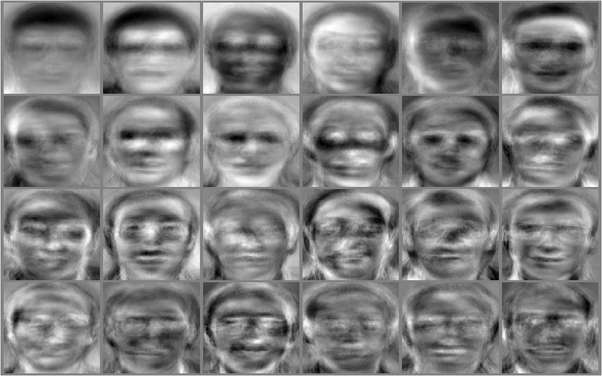

In [55]:
from PIL import Image
import requests

url = 'https://qph.fs.quoracdn.net/main-qimg-5455b701e91f62f4188cd7f6d0714f6c'
im = Image.open(requests.get(url, stream=True).raw)
im

In [56]:
#PCA basically uses eigen values and eigen verctors , the first denotes the variances and the later represents the direction 
# the larger the vairance , the larger the info. available in that particular features 
# the idea of PCA to identify large variance 

# load the numpy zip  
data = np.load('./Data/data/normalized_data.npz')
data.files 

['arr_0', 'arr_1']

In [57]:
X = data['arr_0']
y = data['arr_1']
X.shape , y.shape

((1620, 40000), (1620,))

In [58]:
X1 = X - X.mean(axis=0)

In [59]:
# intialize PCA
# albow method to determine the number of components 
pca = PCA(n_components = None , whiten= True ,svd_solver='auto' )

In [60]:
# PCA is going to calculate the covariance and from that will compute the eigen vectors and eigen values with the help of albow method 
x_pca = pca.fit_transform(X1)

In [61]:
x_pca.shape

(1620, 1620)

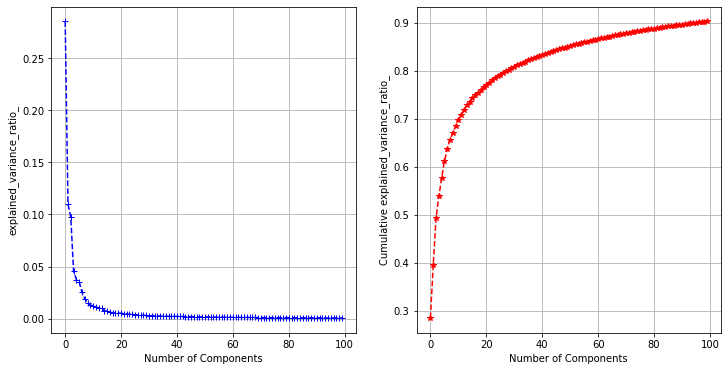

In [62]:
eigen_ratio = pca.explained_variance_ratio_
eigen_ratio_cumsum = np.cumsum(eigen_ratio)

# plot 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(eigen_ratio[:100], 'b+--')
plt.xlabel('Number of Components')
plt.ylabel('explained_variance_ratio_')
plt.grid()
plt.subplot(1,2,2)
plt.plot(eigen_ratio_cumsum[:100], 'r*--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative explained_variance_ratio_')
plt.grid()
plt.show()

In [63]:
# as we can see if we consider only one component , u will have about 10 % of vairance 
# and if it was 2 compon. we will have nearly 40 percent of variance 

# we will consider 30 compon. so we will have 80% of the variance and we will get 
# 80% of the information is available in us dataset
# in the first graph we can see that the optimal number of compon. settle down
# somewhere b/w 10-15 and if we consider it we will get 70% of the variance
# we will consider minimum of 80% so i select 30 number of compon

#conclusion 
# in order to get min 80 percentage variance i will consider 30 compon.
# we defined only 30 directions from 1620 directions 

In [64]:
pca_30 = PCA(n_components = 30 , whiten= True ,svd_solver='auto' )
x_pca_30 = pca_30.fit_transform(X1)
x_pca_30.shape

(1620, 30)

In [65]:
# save data 
pickle.dump(pca_30,open('./Data/data/pca_30.pickle','wb'))


In [66]:
# we defined only 30 directions from 1620 directions 
# consider 30 compon, and inverse transform
# we putting the rest to zero using inverse
x_pca_inverse = pca_30.inverse_transform(x_pca_30)

In [67]:
x_pca_inverse.shape

(1620, 40000)

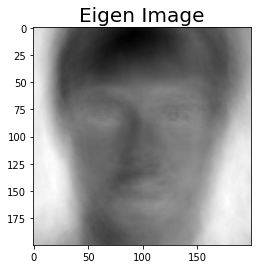

In [68]:
# consedering one image 
eigen_image = x_pca_inverse[0,:]
eigen_image = eigen_image.reshape((200,200))
plt.imshow(eigen_image,cmap='gray')
plt.title('Eigen Image',size=20)
plt.show()

In [69]:
# we are not interested in the corners and what is actually interested in eye ,nose and mouth positions based on that 
# we can identify whether its male or female image
# eigen images instead of taking all the features we are condsedering only important ones 

In [70]:
# save data 
np.savez('./Data/data/data_pca_30.pickle',x_pca_30,y,X.mean())

## Training Machine Learning Model 

In [71]:
# load the data 
data = np.load('./Data/data/data_pca_30.pickle.npz')
data.files

['arr_0', 'arr_1', 'arr_2']

In [72]:
X = data['arr_0']
y = data['arr_1']
mean = data['arr_2']

In [73]:
# split the data to training and testing sets 
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size=0.2,
                                                    stratify=y)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((1296, 30), (324, 30), (1296,), (324,))

In [74]:
# intializing the SupporVectorMachine algo.
model = SVC(C=1.0 , kernel='rbf', gamma=0.01,probability=True)
# fitting the traing data to the model 
model.fit(X_train,y_train)
# check the model accuracy for training and testing set 
print(f'training score : {model.score(X_train, y_train)}')
print(f'testing score : {model.score(X_test, y_test)}')

training score : 0.8402777777777778
testing score : 0.7746913580246914


### Model EValuation 

In [75]:
y_pred = model.predict(X_test)
# probability score for ROC 
y_prob = model.predict_proba(X_test)

In [76]:
############################Confusion Matrix#############################
cm = confusion_matrix(y_test, y_pred)
cm 

array([[ 96,  32],
       [ 41, 155]], dtype=int64)

In [77]:
############################Classification Report#############################

class_report = classification_report(y_test, y_pred, target_names = ['Male','Female']
                           ,output_dict=True)
report = pd.DataFrame(class_report)
report.T

,precision,recall,f1-score,support
Male,0.700730,0.750000,0.724528,128.000000
Female,0.828877,0.790816,0.809399,196.000000
accuracy,0.774691,0.774691,0.774691,0.774691
macro avg,0.764803,0.770408,0.766964,324.000000
weighted avg,0.778251,0.774691,0.775870,324.000000


In [78]:
############################ Kappa #############################
# for a good model the Kappa score must be more than 60% 
# if its less than 40 % so its a poor model 
# if its more than 80% its a perfect model 

cohen_kappa_score(y_test,y_pred)

0.5342994408127903

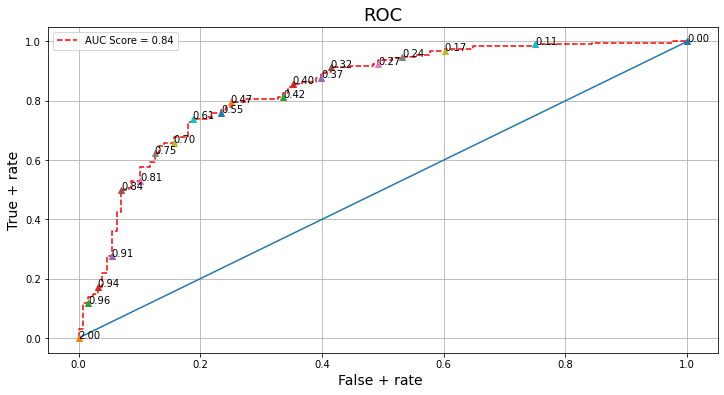

In [79]:
############################ROC and AUC#############################
# ROC for females 
# assign false positive rate , true positive rate and thresh hold value 
fpr ,tpr, thresh = roc_curve(y_test,y_prob[:,1])
auc_score = auc(fpr,tpr)
plt.figure(figsize=(12,6))
plt.plot(fpr,tpr,'r--')
plt.plot([0,1],[0,1],'-')

for i in range(0,len(thresh),5):
    plt.plot(fpr[i],tpr[i],"^")
    plt.text(fpr[i],tpr[i],"%0.2f"%thresh[i])

plt.legend(['AUC Score = %0.2f'%auc_score])
plt.xlabel('False + rate ',size=14)
plt.ylabel('True + rate',size=14)
plt.title('ROC',size=18)
plt.grid()
plt.show()

In [80]:
# its a good model but not the best 

### Model Tunning 

In [81]:
# estimator model , params_grid possible hyperparameters we wanna test with
model_tunning = SVC()
params_grid = {
    'C':[1,10,20,30,50,100],
    'kernel':['rbf','poly'],
    'gamma' : [0.1,0.05,0.01,0.001,0.002,0.005],
    'coef0':[0,1]
}
model_grid = GridSearchCV(model_tunning, param_grid=params_grid,
                         scoring= 'accuracy',cv=5,
                         verbose=1, n_jobs=-1)
model_grid.fit(X,y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 20, 30, 50, 100], 'coef0': [0, 1],
                         'gamma': [0.1, 0.05, 0.01, 0.001, 0.002, 0.005],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [82]:
model_grid.best_index_

2

In [83]:
model_grid.best_params_

{'C': 1, 'coef0': 0, 'gamma': 0.05, 'kernel': 'rbf'}

In [84]:
model_grid.best_score_

0.8111111111111111

In [85]:
# build ML model with best Params 
best_ml = SVC(C= 1, coef0= 0, gamma= 0.05, kernel= 'rbf', probability=True)
best_ml.fit(X_train,y_train)
best_ml.score(X_train,y_train)


0.9513888888888888

In [86]:
y_pred = best_ml.predict(X_test)
# probability score for ROC 
y_prob = best_ml.predict_proba(X_test)
############################Confusion Matrix#############################
cm = confusion_matrix(y_test, y_pred)
cm 

array([[ 88,  40],
       [ 31, 165]], dtype=int64)

In [87]:
############################Classification Report#############################

class_report = classification_report(y_test, y_pred, target_names = ['Male','Female']
                           ,output_dict=True)
report = pd.DataFrame(class_report)
report.T

,precision,recall,f1-score,support
Male,0.739496,0.687500,0.712551,128.000000
Female,0.804878,0.841837,0.822943,196.000000
accuracy,0.780864,0.780864,0.780864,0.780864
macro avg,0.772187,0.764668,0.767747,324.000000
weighted avg,0.779048,0.780864,0.779331,324.000000


In [88]:
cohen_kappa_score(y_test,y_pred)

0.5358728109111452

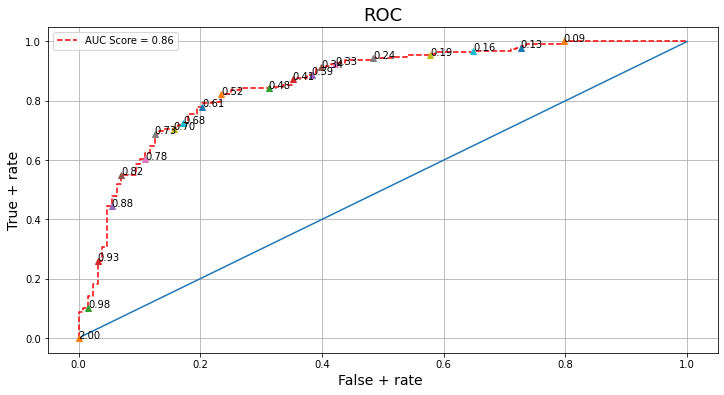

In [89]:
############################ROC and AUC#############################
# ROC for females 
# assign false positive rate , true positive rate and thresh hold value 
fpr ,tpr, thresh = roc_curve(y_test,y_prob[:,1])
auc_score = auc(fpr,tpr)
plt.figure(figsize=(12,6))
plt.plot(fpr,tpr,'r--')
plt.plot([0,1],[0,1],'-')

for i in range(0,len(thresh),5):
    plt.plot(fpr[i],tpr[i],"^")
    plt.text(fpr[i],tpr[i],"%0.2f"%thresh[i])

plt.legend(['AUC Score = %0.2f'%auc_score])
plt.xlabel('False + rate ',size=14)
plt.ylabel('True + rate',size=14)
plt.title('ROC',size=18)
plt.grid()
plt.show()

In [90]:
#save the best model 
pickle.dump(best_ml,open('./Data/data/best_model.pickle','wb'))

In [91]:
pickle.dump(mean,open('./Data/data/mean_preprocessing.pickle','wb'))

Zero-Center Images
Zero centering means that you process your image so that the mean of your image lies on the zero. Mathematically this can be done by calculating the mean in your images and subtracting each image item with that mean.